# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

29972


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\AB_compartment_th_zero\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   

In [6]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


In [7]:
# this is the plotting order noted based on the snRNA transcriptional acitivty;
# we'd use this for all the graphs in this notebook
# use the snRNA data below (# section 3.1.1) if needs to re-calculate
sorted_cellplot_order = ['Micro', 'Oligo', 'Endo', 'OPC', 'Astro', 'Vip', 'Lamp5',
                  'L5/6 NP', 'Sst', 'Sncg', 'Pvalb', 'L4/5 IT', 'L6 CT',
                  'L6 IT', 'L6b', 'L2/3 IT', 'L5 IT', 'L5 ET']

# 2. Load codebook

## Codebook

Example of [codebook](../../postanalysis/0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [8]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


# 3. Load Transcription summary


Data below can be generated by the notebook:

[0_locus_annotation/scripts/5_majortype_atac_and_rna_means_by_loci](../0_locus_annotation/scripts/5_majortype_atac_and_rna_means_by_loci.ipynb)

In [9]:
import tqdm
sel_class_list = ['Gluta','GABA','Oligo','Astro','Endo','Micro']
ref_measure_dict_byGroup = {}

for _class in tqdm.tqdm(sel_class_list):
    _class_name = _class.replace(' ','_').replace('/','_')
    #print(_class_name)
    rna_atac_fname = os.path.join(output_analysis_folder,f'MajorType_{_class_name}_snATAC_snRNA_mean_by_loci.csv')
    if os.path.exists(rna_atac_fname):
        rna_atac_df = pd.read_csv(rna_atac_fname,index_col=0)
        ref_measure_dict_byGroup[_class] = rna_atac_df[:-1]

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 57.57it/s]


In [10]:
ref_measure_dict_byGroup[_class]

,loci_name,mean_ATAC_2X_2000kb,mean_rna_2X_2000kb,mean_rna_2X_200kb
0,chr1_3742742_3759944,1.391338,0.907407,0.462963
1,chr1_6245958_6258969,1.774731,1.925926,0.777778
2,chr1_8740008_8759916,2.144798,3.240741,0.000000
3,chr1_9627926_9637875,2.246028,2.759259,0.870370
4,chr1_9799472_9811359,2.271399,2.759259,0.703704
...,...,...,...,...
1976,chrX_163750534_163758706,1.507688,1.462963,0.500000
1977,chrX_166247682_166259932,2.507688,2.870370,0.666667
1978,chrX_167157164_167167452,2.485648,3.314815,1.870370
1979,chrX_168746045_168757590,2.334956,3.351852,0.574074


# 4. Load ABcompartment binary

Data below can be generated by the notebook as

[2_ab_compartment_assignment_threshold_zero](2_ab_compartment_assignment_threshold_zero.ipynb)

In [11]:
group_ABs_id_df = pd.read_csv(os.path.join(output_analysis_folder,'AB_assignment_shared_ABth_zero.csv'), index_col=0)
group_ABs_id_df

,Astro,Endo,GABA,Gluta,Micro,Oligo
loci_name,,,,,,
chr1_3742742_3759944,B,B,B,B,B,B
chr1_6245958_6258969,A,B,B,B,B,B
chr1_8740008_8759916,B,B,B,B,B,B
chr1_9627926_9637875,A,B,B,B,A,B
chr1_9799472_9811359,A,B,B,B,A,A
...,...,...,...,...,...,...
chrX_163750534_163758706,A,A,A,A,A,A
chrX_166247682_166259932,A,A,A,A,A,A
chrX_167157164_167167452,A,A,A,A,A,A


# 5. Convert to summary df

In [12]:
group_ABs_id_df.columns.tolist()

['Astro', 'Endo', 'GABA', 'Gluta', 'Micro', 'Oligo']

In [13]:
# process
AB_summary_dict = {'AB_compartment':[],'rna':[],'ATAC':[],
                    'loci':[],'celltype':[],'chr':[],}
for _group in ref_measure_dict_byGroup.keys():
    # AB id
    if _group in group_ABs_id_df.columns.tolist():
        AB_summary_dict['AB_compartment'].extend(group_ABs_id_df[_group].tolist())
    else:
        AB_summary_dict['AB_compartment'].extend([np.nan]*len(group_ABs_id_df))
    # other info            
    AB_summary_dict['loci'].extend(group_ABs_id_df.index.tolist())
    AB_summary_dict['celltype'].extend([_group]*len(group_ABs_id_df))
    AB_summary_dict['chr'].extend([i.split('_')[0] for i in group_ABs_id_df.index.tolist()])
    
    rna_atac_df = ref_measure_dict_byGroup[_group]
    if len(rna_atac_df)==len(group_ABs_id_df):
        for _mode in ['rna', 'ATAC']:
            AB_summary_dict[_mode].extend(rna_atac_df[f'mean_{_mode}_2X_2000kb'].tolist())
    else:
        for _mode in ['rna', 'ATAC']:
            AB_summary_dict[_mode].extend([np.nan]*len(group_ABs_id_df))

AB_summary_df = pd.DataFrame(AB_summary_dict)
AB_summary_df

,AB_compartment,rna,ATAC,loci,celltype,chr
0,B,21.495658,3.801971,chr1_3742742_3759944,Gluta,chr1
1,B,11.692570,4.195687,chr1_6245958_6258969,Gluta,chr1
2,B,31.264248,5.626522,chr1_8740008_8759916,Gluta,chr1
3,B,38.439871,6.081351,chr1_9627926_9637875,Gluta,chr1
4,B,38.439871,6.252073,chr1_9799472_9811359,Gluta,chr1
...,...,...,...,...,...,...
11881,A,1.462963,1.507688,chrX_163750534_163758706,Micro,chrX
11882,A,2.870370,2.507688,chrX_166247682_166259932,Micro,chrX
11883,A,3.314815,2.485648,chrX_167157164_167167452,Micro,chrX
11884,A,3.351852,2.334956,chrX_168746045_168757590,Micro,chrX


# 6. Check RNA change during compartment change

## AB changes between celltypes

In [14]:
sel_cell_groups = np.unique(AB_summary_df['celltype']).tolist()
sel_cell_groups = ['Oligo','Astro','GABA','Gluta',]
sel_cell_groups = ['Micro', 'Endo','Oligo','Astro','GABA','Gluta',]
sel_cell_groups

['Micro', 'Endo', 'Oligo', 'Astro', 'GABA', 'Gluta']

In [15]:
from itertools import combinations
compare_pairs = list(combinations(sel_cell_groups,2))
compare_pairs

[('Micro', 'Endo'),
 ('Micro', 'Oligo'),
 ('Micro', 'Astro'),
 ('Micro', 'GABA'),
 ('Micro', 'Gluta'),
 ('Endo', 'Oligo'),
 ('Endo', 'Astro'),
 ('Endo', 'GABA'),
 ('Endo', 'Gluta'),
 ('Oligo', 'Astro'),
 ('Oligo', 'GABA'),
 ('Oligo', 'Gluta'),
 ('Astro', 'GABA'),
 ('Astro', 'Gluta'),
 ('GABA', 'Gluta')]

In [16]:
AB_change_types = ['A to A','B to B','A to B','B to A',]
measure_mode = 'rna'
change_summary_dict = {'compartment_change':[], f'log2_{measure_mode}_change':[],'loci':[], 'celltype_change':[] }



for _group1, _group2 in compare_pairs:
#_group1 = 'Gluta'
#_group2 = 'GABA'

    measure_mode = 'rna'

    AB_summary_df_g1 = AB_summary_df[AB_summary_df['celltype']==_group1]
    AB_summary_df_g2 = AB_summary_df[AB_summary_df['celltype']==_group2]



    change_summary_dict[f'log2_{measure_mode}_change'].extend(np.log2(np.array(AB_summary_df_g2[measure_mode])/
                                                                      np.array(AB_summary_df_g1[measure_mode])))
    change_summary_dict['compartment_change'].extend([f'{i} to {j}' for i, j in zip(list(AB_summary_df_g1['AB_compartment']),
                                                         list(AB_summary_df_g2['AB_compartment']))])
    change_summary_dict['loci'].extend(AB_summary_df_g1['loci'].tolist())
    change_summary_dict['celltype_change'].extend([f'{_group1} to {_group2}']*len(AB_summary_df_g1))

change_summary_df = pd.DataFrame(change_summary_dict)
change_summary_df = change_summary_df[change_summary_df['compartment_change'].isin(AB_change_types)]

def rename_comp_change (comp_change_type):
    if comp_change_type in ['A to A','B to B'] :
        return 'No change'
    else:
        return comp_change_type

change_summary_df['compartment_change_new'] =  change_summary_df['compartment_change'].map(lambda x: rename_comp_change(x))


change_summary_df.head()

C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_29972\1159938651.py:18: RuntimeWarning: divide by zero encountered in divide
  change_summary_dict[f'log2_{measure_mode}_change'].extend(np.log2(np.array(AB_summary_df_g2[measure_mode])/
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_29972\1159938651.py:18: RuntimeWarning: invalid value encountered in divide
  change_summary_dict[f'log2_{measure_mode}_change'].extend(np.log2(np.array(AB_summary_df_g2[measure_mode])/
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_29972\1159938651.py:18: RuntimeWarning: divide by zero encountered in log2
  change_summary_dict[f'log2_{measure_mode}_change'].extend(np.log2(np.array(AB_summary_df_g2[measure_mode])/


,compartment_change,log2_rna_change,loci,celltype_change,compartment_change_new
0,B to B,2.745899,chr1_3742742_3759944,Micro to Endo,No change
1,B to B,2.231326,chr1_6245958_6258969,Micro to Endo,No change
2,B to B,0.745899,chr1_8740008_8759916,Micro to Endo,No change
3,A to B,1.151708,chr1_9627926_9637875,Micro to Endo,A to B
4,A to B,1.151708,chr1_9799472_9811359,Micro to Endo,A to B


## Plot

In [19]:
np.unique(change_summary_df['celltype_change'])

sel_celltype_change = [c for c in np.unique(change_summary_df['celltype_change']) if 'Endo' not in c]
sel_celltype_change = [c for c in sel_celltype_change if 'Micro' not in c]
sel_celltype_change

['Astro to GABA',
 'Astro to Gluta',
 'GABA to Gluta',
 'Oligo to Astro',
 'Oligo to GABA',
 'Oligo to Gluta']

In [23]:
sub_sel_change_summary_df

,compartment_change,log2_rna_change,loci,celltype_change,compartment_change_new
21791,B to B,2.699538,chr1_3742742_3759944,Oligo to Gluta,No change
21792,B to B,-0.120785,chr1_6245958_6258969,Oligo to Gluta,No change
21793,B to B,2.556742,chr1_8740008_8759916,Oligo to Gluta,No change
21794,B to B,2.937367,chr1_9627926_9637875,Oligo to Gluta,No change
21795,A to B,2.937367,chr1_9799472_9811359,Oligo to Gluta,A to B
...,...,...,...,...,...
23767,A to A,2.084706,chrX_163750534_163758706,Oligo to Gluta,No change
23768,A to A,1.175086,chrX_166247682_166259932,Oligo to Gluta,No change
23769,A to A,2.659769,chrX_167157164_167167452,Oligo to Gluta,No change
23770,A to A,3.765603,chrX_168746045_168757590,Oligo to Gluta,No change


In [24]:
sub_sel_change_summary_df[sub_sel_change_summary_df['compartment_change_new']==]['log2_rna_change']

Astro to GABA :    F_onewayResult(statistic=10.96390967943681, pvalue=1.8435061910789052e-05)
Astro to GABA Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.314     0.000    -0.497    -0.130
 (0 - 2)     -0.485     0.000    -0.746    -0.225
 (1 - 0)      0.314     0.000     0.130     0.497
 (1 - 2)     -0.172     0.129    -0.380     0.036
 (2 - 0)      0.485     0.000     0.225     0.746
 (2 - 1)      0.172     0.129    -0.036     0.380



meta NOT subset; don't know how to subset; dropped


Astro to Gluta :    F_onewayResult(statistic=17.64287689756562, pvalue=2.558175763662429e-08)
Astro to Gluta Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.466     0.000    -0.657    -0.275
 (0 - 2)     -0.546     0.000    -0.813    -0.279
 (1 - 0)      0.466     0.000     0.275     0.657
 (1 - 2)     -0.080     0.642    -0.290     0.129
 (2 - 0)      0.546     0.000     0.279     0.813
 (2 - 1)      0.080     0.642    -0.129     0.290



meta NOT subset; don't know how to subset; dropped


GABA to Gluta :    F_onewayResult(statistic=17.77295391719333, pvalue=2.2512998808668632e-08)
GABA to Gluta Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.296     0.000    -0.425    -0.167
 (0 - 2)     -0.408     0.000    -0.578    -0.237
 (1 - 0)      0.296     0.000     0.167     0.425
 (1 - 2)     -0.112     0.080    -0.233     0.010
 (2 - 0)      0.408     0.000     0.237     0.578
 (2 - 1)      0.112     0.080    -0.010     0.233



meta NOT subset; don't know how to subset; dropped


Oligo to Astro :    F_onewayResult(statistic=16.641904421537426, pvalue=6.870140658144199e-08)
Oligo to Astro Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.359     0.000    -0.537    -0.182
 (0 - 2)     -0.570     0.000    -0.806    -0.333
 (1 - 0)      0.359     0.000     0.182     0.537
 (1 - 2)     -0.210     0.011    -0.381    -0.040
 (2 - 0)      0.570     0.000     0.333     0.806
 (2 - 1)      0.210     0.011     0.040     0.381



meta NOT subset; don't know how to subset; dropped


Oligo to GABA :    F_onewayResult(statistic=41.80579823782318, pvalue=1.7520973627670184e-18)
Oligo to GABA Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.463     0.000    -0.616    -0.309
 (0 - 2)     -0.838     0.000    -1.059    -0.618
 (1 - 0)      0.463     0.000     0.309     0.616
 (1 - 2)     -0.376     0.000    -0.551    -0.200
 (2 - 0)      0.838     0.000     0.618     1.059
 (2 - 1)      0.376     0.000     0.200     0.551



meta NOT subset; don't know how to subset; dropped


Oligo to Gluta :    F_onewayResult(statistic=35.35004950167042, pvalue=8.60329335269116e-16)
Oligo to Gluta Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.428     0.000    -0.587    -0.269
 (0 - 2)     -0.781     0.000    -1.002    -0.561
 (1 - 0)      0.428     0.000     0.269     0.587
 (1 - 2)     -0.353     0.000    -0.526    -0.181
 (2 - 0)      0.781     0.000     0.561     1.002
 (2 - 1)      0.353     0.000     0.181     0.526



meta NOT subset; don't know how to subset; dropped


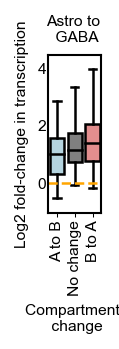

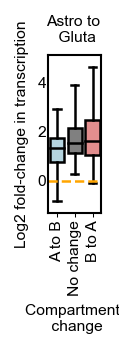

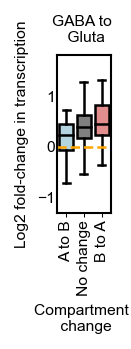

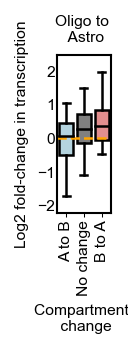

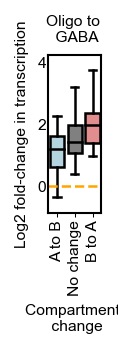

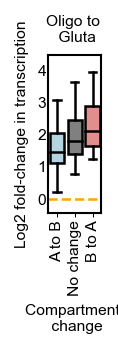

In [48]:
import seaborn as sns
from scipy.stats import tukey_hsd
from scipy.stats import f_oneway
#sel_change_summary_df = change_summary_df[change_summary_df['compartment_change'].isin(['A to B','B to A'])]
sel_change_summary_df = change_summary_df.copy(deep=True)


AB_change_types_colors = {'B to A':'lightcoral','No change':'gray','A to B':'lightblue'}


#for _celltype_change in np.unique(change_summary_df['celltype_change']):
for _celltype_change in sel_celltype_change:    
    
    sub_sel_change_summary_df = sel_change_summary_df[sel_change_summary_df['celltype_change']==_celltype_change]
    #sns.set(style="whitegrid")
    fig,ax=plt.subplots(figsize=(_page_width/12,_page_width/12*3), dpi=150)
    sns.boxplot(data=sub_sel_change_summary_df, y ='log2_rna_change', x='compartment_change_new', 
                order = ['A to B', 
                         #'B to B', 'A to A', 
                         'No change',
                         'B to A',],
                palette = AB_change_types_colors,
                whis=[5, 95],
                ax=ax, fliersize=0,
                boxprops = {'edgecolor':'black'},
                medianprops = {'color':'black'},
                whiskerprops = {'color':'black'},
                capprops = {'color':'black'},
                
               )
    ymin = np.nanpercentile(sub_sel_change_summary_df[sub_sel_change_summary_df['compartment_change_new']=='A to B']
                            ['log2_rna_change'],5) - 0.5
    
    ymax = np.nanpercentile(sub_sel_change_summary_df[sub_sel_change_summary_df['compartment_change_new']=='B to A']
                            ['log2_rna_change'],95) + 0.5
    plt.ylim(ymin,ymax)
    
    ax.tick_params('x', labelsize=_font_size, 
                width=_ticklabel_width, length=_ticklabel_size, rotation=90,
                pad=1, labelbottom=True) # remove bottom ticklabels for _ax
    ax.tick_params('y', labelsize=_font_size, 
                        width=_ticklabel_width, length=0,
                        pad=1, labelleft=True)

    ax.set_ylabel('Log2 fold-change in transcription', fontsize=_font_size)
    ax.set_xlabel('Compartment \n change', fontsize=_font_size)
    _cls1 = _celltype_change.split(' ')[0]
    _cls2 = _celltype_change.split(' ')[2]
    ax.set_title(f'{_cls1} to \n {_cls2}', fontsize=_font_size)
    # show the graph
    ax.grid(False)
    ax.axhline(0, c='orange', linestyle='--')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        
        
    # perform stats
    stats_groups = []
    for AB_change_type in ['A to B', 'No change', 'B to A']:
        val_group = sub_sel_change_summary_df[sub_sel_change_summary_df['compartment_change_new']==AB_change_type]['log2_rna_change']
        val_group = np.array(val_group)
        stats_groups.append(val_group[np.isfinite(val_group)])
        
    res_oneway = f_oneway(stats_groups[0], stats_groups[1], stats_groups[2])
    print(_celltype_change, ':   ', res_oneway)
    if res_oneway[1]<0.05:
        res = tukey_hsd(stats_groups[0], stats_groups[1], stats_groups[2])
        print(_celltype_change, res)
    else:
        print('NS. Skip the correction.')
    
    plt.savefig(os.path.join(output_figure_folder,f'ABcompartment_change_w_transcription_{_celltype_change}.pdf'),
                    transparent=True, bbox_inches='tight', pad_inches=0.2, dpi=300)


